# MOOC : Évaluez et améliorez les performances d'un modèle de machine learning
****
### Excercice : Implémentez une validation croisée

***Travail à faire :***

Ré-implémenter la fonction de validation croisée de la libraire scikit-learn, dans l’objectif d’effectuer la classification du dataset sur la qualité du vin. Pour cela, vous pourrez réutiliser le code du TP du chapitre précédent comme base de travail.


***Livrable :***

Vous devrez mettre sur la plateforme un .zip contenant : 
- le classeur avec l’implémentation de la fonction.
- le code modifié du TP permettant l’application et l’évaluation du K-nn avec votre fonction de validation croisée.

Pour rappel les données sont à télécharger ici : http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/

#### Table des matières
1. [Chargement des données](#data_loading)
- [Affichage des données](#data-showing)
- [Traitement sur le jeu de données](#data-normalizing)
- <b>[Définition de la fonction de validation croisée](#cross-validation-function)</b>
- [Lancement de la validation croisée](#data-validating)
- [Evalution de la performance du jeu de test](#Perf_test)
****
<u>_Configutation logicielle :_</u> Python 3.6 installé avec la suite Anaconda

<table align='left'>
    <TH>Packages</th><th>Versions</TH>
    <TR><td>numpy</td><td>1.13.3</td></TR>
    <TR><td>_matplotlib_</td><td>2.1.0</td></TR>
    <TR><td>_pandas_</td><td>0.21.0</td></TR>
    <TR><td>_scikit-learn_</td><td>0.19.1</td></TR>
</table>    

*****
### Chargement des données <a id="data_loading"></a>

In [1]:
#Import des modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import des données
datapath='.\\data\\'
datafile='winequality-white.csv'
data = pd.read_csv(datapath+datafile, sep=';')
print(data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

### Affichage des données <a id="data-showing"></a>

C:\Users\jdouet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\jdouet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\jdouet\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


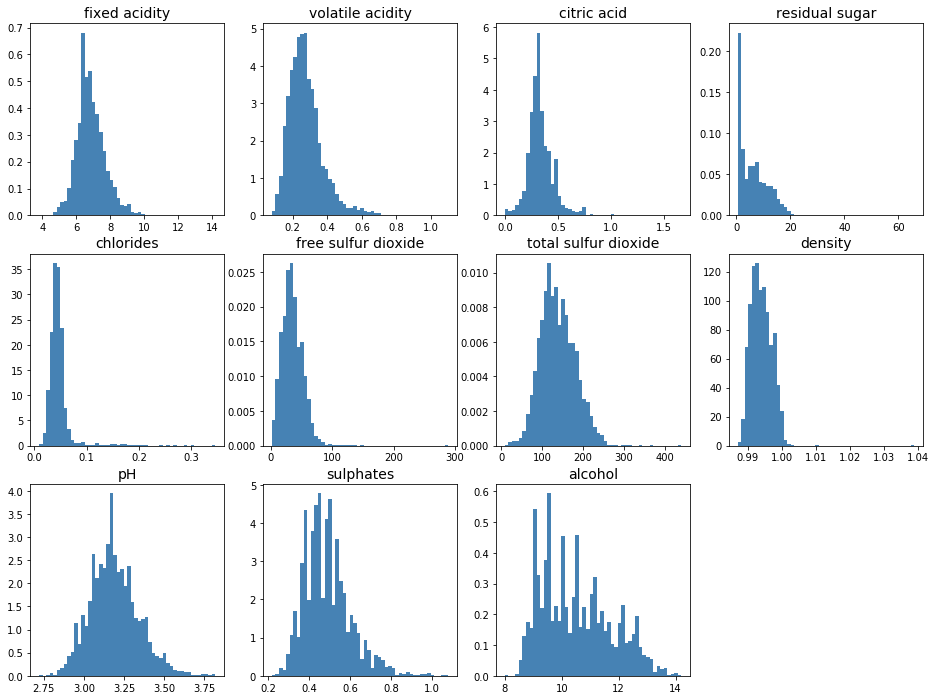

In [2]:
X = data.as_matrix(data.columns[:-1])
y = data.as_matrix([data.columns[-1]])
y = y.flatten()
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue',
                normed=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)
plt.show()

### Traitement sur le jeu de données <a id="data-normalizing"></a>
- Labellisation des bons vins (crus)
- Séparation du jeu d'entrainement et du jeu de test
- Standardisation des données

C:\Users\jdouet\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


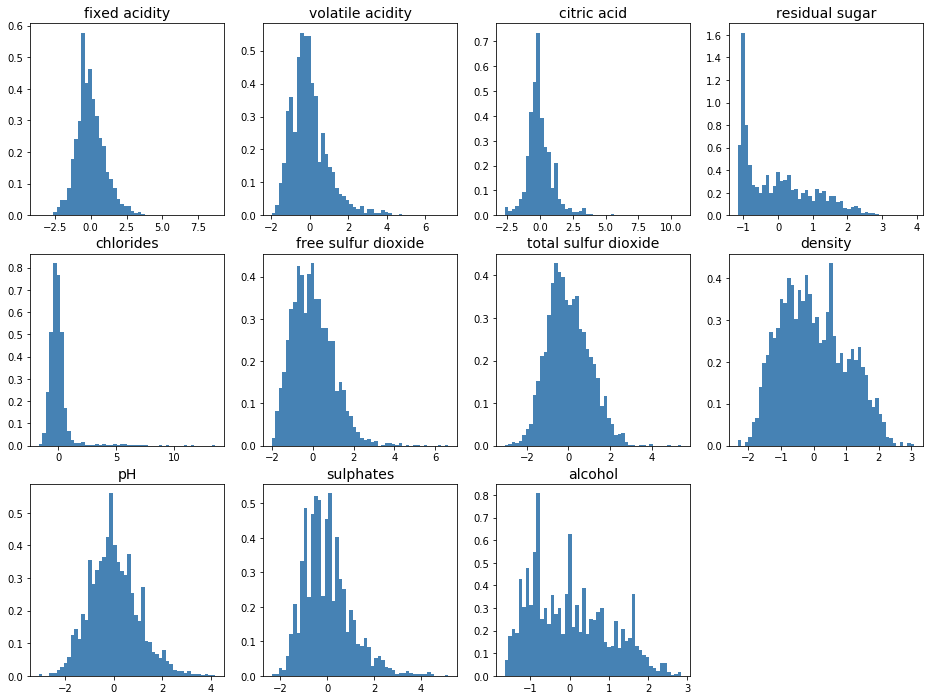

In [3]:
# Les vins ayant une note supérieure ou égale à 6 sont considérés commme des crus
y_class = np.where(y<6, 0, 1)

# Séparation jeu d'entrainement (70%) et jeu de test (30%)
from sklearn import model_selection
X_train, X_test, y_train, y_test = \
model_selection.train_test_split(X, y_class,
                                 test_size=0.3 # 30% des données dans le jeu de test
                                )

# Standardisation des données d'entrainement
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

# .. Affichage des données standardisées
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X_train_std[:, feat_idx], bins=50, color='steelblue',
                normed=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)
plt.show()

### Fonction de validation croisée <a id="cross-validation-function"></a>
- Classe __`CrossValidation`__ : re-implémentaion de l'objet `GridSearchCV` utilisé dans le cours, restreint à ce qui est demandé dans cet exercice
    - `__init__` : Initialise l'objet avec les paramètre suivant : 
        - _classifier_ : Nom de la classe "classifieur" à utiliser pour l'entrainemenet
        - _param_grid_ : Grille de paramètres à utiliser dans la recherche de la meilleur performance
        - _cv_ : Nombre de découpage à faire dans le jeu de données d'entrainement
    - `fit` : Fonction d'entrainemenet
        - Recherche le meilleur modèle selon la grille de paramètre défini lors de la création de l'objet
        - Entraine le modèle avec les meilleurs paramètres
        
    - `predict` : Fonction de prédiction sur le modèle entrainer avec la fonction `fit`
    - `_set_list_dataset_` : Fonction de découpage du jeu d'entraine en n sous-ensembles. Le nombre de sous-ensemble est défini à la création de l'objet avec le paramètre `cv`
    - `_select_training_set_` : Fonction de contruction du jeu d'entrainement et du jeu de validation. L'argument `validate_fold_index` défini le sous-ensemble à utiliser comme jeu de validation.
    - `_iter_param_` : Fonction d'itération permettant de sélectionner succéssivement les hyper-paramètres du modèle à utiliser dans la recherche du meilleur modèle.
    
    
- Fonction __`prod_lists`__ : Effectue le produit de plusieurs liste

    <em><u>Exemple :</u>
    
    Liste_1 = ['Valeur 1', 'Valeur 2']<BR />
    Liste_2 = ['Valeur 3', 'Valeur 4']<BR />
    Liste_1 x Liste_2 =
        [['Valeur 1', 'Valeur 3']
         ['Valeur 1', 'Valeur 4']
         ['Valeur 2', 'Valeur 3']
         ['Valeur 2', 'Valeur 4']]
    </em>     
    La fonction prend en paramètre une liste de listes pour faire le produit : [Liste_1, Liste_2]
         

In [4]:
from sklearn import model_selection

def prod_lists(list_lists):
    """Return the product of elements' list in the list 'list_lists' """
    _prod_lists_ = []
    for item_list in list_lists:
        prod_copy = _prod_lists_.copy()
        _prod_lists_ = []
        if len(prod_copy) == 0:
            for item in item_list:
                _prod_lists_.append([item])
        else: 
            for item in item_list:
                for sublist in prod_copy:
                    sub_copy=sublist.copy()
                    sub_copy.append(item)
                    _prod_lists_.append(sub_copy)
    return _prod_lists_

class CrossValidation:
    def __init__(self,
                 classifier,
                 param_grid,
                 cv=2):
        self.classifier = classifier
        self.param_grid = param_grid
        self.nb_folds = cv
        
        self._list_training_set_ = []
        self._list_labels_set_ = []
        self.cv_results_ = {'params' : [] # Liste des hyper-paramètres
                            ,'scores_list' : [] # Liste de la liste des scores
                            ,'mean_test_score' : [] # Liste de la moyenne des scores
                            ,'std_test_score' : []  # liste des écarts-type
                           } 
        self.best_params_ = {}
        self._classifier_ = None
        
    # Fonction d'entrainement    
    def fit(self, training_set, labels_set):
        """Training model with cross validation"""
        
        # Découpage de données;
        self._set_list_dataset_(training_set,labels_set)
        
        # Entrainement et calcul de l'erreur
        # Pour chaque valeur de paramètre
        for param in self._iter_param_():
            # Pour chq fold
            fold_result = []
            for index_fold in range(self.nb_folds-1):
                # Sélectionner les données d'entrainement
                X_train, X_test, y_train, y_test = self._select_training_set_(index_fold)
                # Lancer la fonction avec les paramètres 
                clf = self.classifier(**param )
                clf.fit(X_train, y_train)
                
                # Evaluer le score
                fold_result.append(clf.score(X_test,y_test)) 
            # Calcul la marge d'erreur (écart entre les jeu d'entrainement)
            self.cv_results_['params'].append(param)
            self.cv_results_['scores_list'].append(fold_result)
            self.cv_results_['mean_test_score'].append(np.mean(fold_result))
            self.cv_results_['std_test_score'].append(np.std(fold_result))
            
        # Conclure les meilleurs paramètres
        self.best_params_ = self.cv_results_['params'][self.cv_results_['mean_test_score'].index(max(self.cv_results_['mean_test_score']))]

        # Entrainement du modèle avec les meilleurs paramètre
        self._classifier_ = self.classifier(**self.best_params_)
        self._classifier_.fit(training_set,labels_set)
    
    def predict(self, X):
        """Return the predict values with the best params"""
        return self._classifier_.predict(X)

        
    # Fonction de découpage des données
    def _set_list_dataset_(self,training_set, labels_set):
        self._list_training_set_ = []
        self._list_labels_set_ = []
        X_remaining = training_set
        y_remaining = labels_set
        for i in range(self.nb_folds,2,-1):
            size = 1/i
            X_fold, X_remaining, y_fold, y_remaining = model_selection.train_test_split(
                    X_remaining, y_remaining, test_size=size)
            self._list_training_set_.append(X_fold)
            self._list_labels_set_.append(y_fold)
        self._list_training_set_.append(X_remaining)
        self._list_labels_set_.append(y_remaining)
        
    # Fonction de construction du training set 
    # en fonction de l'indexe du fold de validation
    def _select_training_set_(self, validate_fold_index):
        X_train = np.ndarray(shape=(0,self._list_training_set_[0].shape[1]))
        y_train = np.ndarray(shape=(0,))
        
        for i in range(self.nb_folds-1):
            if i != validate_fold_index:
                X_test = self._list_training_set_[i]
                y_test = self._list_labels_set_[i]
            else:
                X_train = np.append(X_train, self._list_training_set_[i],axis=0)
                y_train = np.append(y_train, self._list_labels_set_[i])
        return X_train, X_test, y_train, y_test
            
    # Fonction d'itération sur les hyper-paramètres    
    def _iter_param_(self):
        """itère sur la grille des paramètres"""
        for p in [self.param_grid]:
            items = sorted(p.items())
            keys, values = zip(*items)
            values=prod_lists(values)
            for v in values:
                params = dict(zip(keys, v))
                yield params

### Lancement de la validation croisées <a id="data-validating"></a>

In [5]:
from sklearn import neighbors, metrics

# Fixation des paramètres
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}
nb_folds = 5

# Création d'un classifier kNN
clf = CrossValidation(neighbors.KNeighborsClassifier,
                     param_grid,
                     cv=nb_folds)

# Lancement de l'entrainement
clf.fit(X_train_std, y_train)

# Afficher l'hyperparamètre optimal
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:"),
print(clf.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(clf.cv_results_['mean_test_score'], # score moyen
                             clf.cv_results_['std_test_score'], # écart-type du score
                             clf.cv_results_['params'] # valeur de l'hyperparamètre
                            ):
    print("\t%s = %0.3f (+/-%0.03f) for %r" % ('accuracy', # critère utilisé
                                               mean, # score moyen
                                               std * 2, # barre d'erreur
                                               params # hyperparamètre
                                              ))




Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 15}
Résultats de la validation croisée :
	accuracy = 0.731 (+/-0.054) for {'n_neighbors': 3}
	accuracy = 0.717 (+/-0.052) for {'n_neighbors': 5}
	accuracy = 0.723 (+/-0.037) for {'n_neighbors': 7}
	accuracy = 0.714 (+/-0.020) for {'n_neighbors': 9}
	accuracy = 0.731 (+/-0.042) for {'n_neighbors': 11}
	accuracy = 0.719 (+/-0.046) for {'n_neighbors': 13}
	accuracy = 0.736 (+/-0.054) for {'n_neighbors': 15}


#### Performance du jeu de test  <a id="Perf_test"></a>

In [6]:
y_pred = clf.predict(X_test_std)
print("\nSur le jeu de test : %0.3f" % metrics.accuracy_score(y_test, y_pred))


Sur le jeu de test : 0.768
